In [8]:
import pandas as pd

anime = pd.read_csv("anime.csv")
ratings = pd.read_csv("rating.csv")

# İlk birkaç satırı görüntüle
display(anime.head())
display(ratings.head())


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [9]:
# Veri şekilleri
print("Anime veri boyutu:", anime.shape)
print("Rating veri boyutu:", ratings.shape)

# Eksik veri kontrolü
print("\nEksik değerler:")
print(anime.isnull().sum())

# Türlerden bazı örnekler
print("\nÖrnek türler:")
print(anime['genre'].dropna().unique()[:10])

Anime veri boyutu: (12294, 7)
Rating veri boyutu: (7813737, 3)

Eksik değerler:
anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

Örnek türler:
['Drama, Romance, School, Supernatural'
 'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen'
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen'
 'Sci-Fi, Thriller' 'Comedy, Drama, School, Shounen, Sports'
 'Action, Adventure, Shounen, Super Power'
 'Drama, Military, Sci-Fi, Space'
 'Drama, Fantasy, Romance, Slice of Life, Supernatural'
 'Drama, School, Shounen'
 'Action, Drama, Mecha, Military, Sci-Fi, Super Power']


In [ ]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=831163 sha256=21719adc2b3eb4348633cde21f93f0f62767ae0198fc4ee982b201bbfaa6e1d5
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm


In [10]:
import pandas as pd
import numpy as np
from lightfm import LightFM
from lightfm.data import Dataset

In [11]:
# Dosyaları oku
anime = pd.read_csv("anime.csv")
ratings = pd.read_csv("rating.csv")

# -1 puanları kaldır (izlenmemiş)
ratings = ratings[ratings['rating'] != -1]


In [12]:
# Kullanıcı ve anime ID'lerini tanımla
dataset = Dataset()
dataset.fit(ratings['user_id'], ratings['anime_id'])


In [15]:
# İlk 100.000 satırı al
ratings_sample = ratings.sample(n=100000, random_state=42)


In [17]:
model = LightFM(loss='warp')  # warp = Weighted Approximate-Rank Pairwise
model.fit(interactions, epochs=10, num_threads=2)

In [16]:
dataset = Dataset()
dataset.fit(ratings_sample['user_id'], ratings_sample['anime_id'])

(interactions, weights) = dataset.build_interactions([
    (row['user_id'], row['anime_id'], row['rating'])
    for index, row in ratings_sample.iterrows()
])


In [18]:
def recommend_anime_lightfm(model, dataset, user_id, anime_df, ratings_df, n=5):
    all_anime = anime_df['anime_id'].unique()
    watched = ratings_df[ratings_df['user_id'] == user_id]['anime_id'].tolist()
    unseen = [aid for aid in all_anime if aid not in watched]

    user_map = dataset.mapping()[0]
    item_map = dataset.mapping()[2]

    user_x = user_map.get(user_id)
    item_xs = [item_map.get(aid) for aid in unseen if aid in item_map]

    scores = model.predict(user_x, item_xs)
    top_items = np.argsort(-scores)[:n]

    top_ids = [unseen[i] for i in top_items]
    return anime_df[anime_df['anime_id'].isin(top_ids)][['name', 'genre', 'rating']]


In [19]:
recommend_anime_lightfm(model, dataset, user_id=1, anime_df=anime, ratings_df=ratings)


,name,genre,rating
1,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",9.26
126,Steins;Gate: Oukoubakko no Poriomania,"Sci-Fi, Thriller",8.46
198,Berserk: Ougon Jidai-hen III - Kourin,"Action, Adventure, Demons, Drama, Fantasy, Hor...",8.33
799,Mobile Police Patlabor 2: The Movie,"Drama, Mecha, Mystery, Police, Sci-Fi",7.83
1506,Outbreak Company,"Comedy, Fantasy, Harem, Parody",7.52


<ipython-input-20-b3278dcba6d0>:18: UserWarning: Glyph 127884 (\N{CROSSED FLAGS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127884 (\N{CROSSED FLAGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


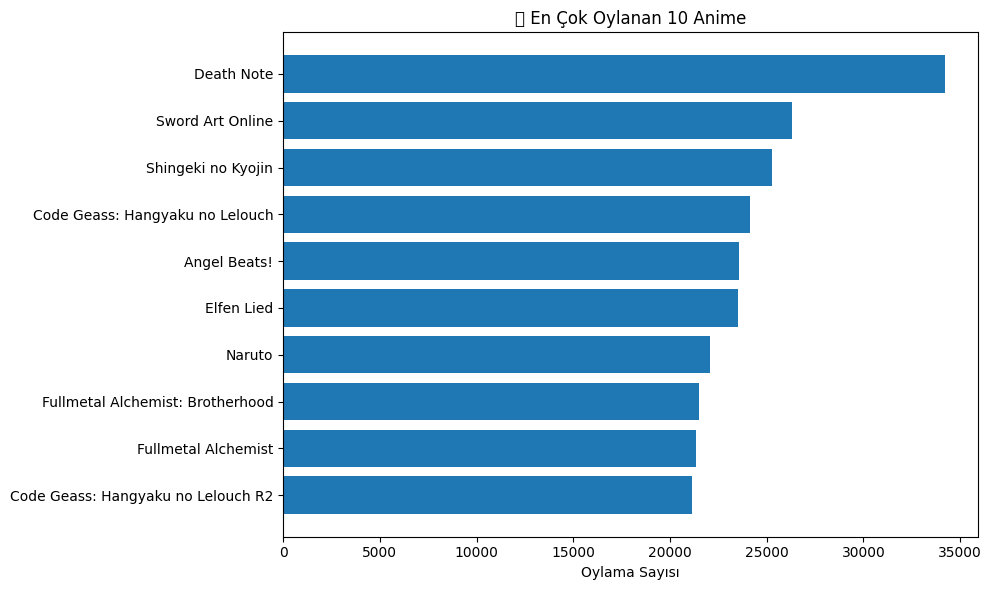

In [20]:
# Her animeye verilen oy sayısı
anime_vote_counts = ratings.groupby('anime_id')['rating'].count().reset_index()
anime_vote_counts.columns = ['anime_id', 'vote_count']

# Anime isimleriyle birleştir
anime_popular = anime_vote_counts.merge(anime[['anime_id', 'name']], on='anime_id')

# En çok oylanan ilk 10 anime
top_anime = anime_popular.sort_values('vote_count', ascending=False).head(10)

# Grafik
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(top_anime['name'][::-1], top_anime['vote_count'][::-1])
plt.title('🎌 En Çok Oylanan 10 Anime')
plt.xlabel('Oylama Sayısı')
plt.tight_layout()
plt.show()


<ipython-input-21-772548fba878>:19: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


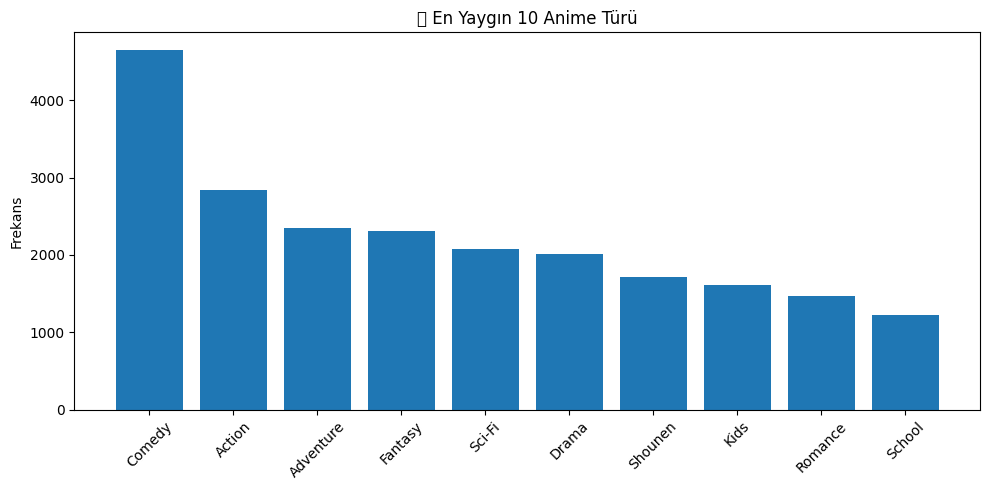

In [21]:
# Tür bilgileri boş olmayanları al
genres = anime[anime['genre'].notnull()]

# Tüm türleri ayır (çoklu türleri böl)
all_genres = genres['genre'].str.split(', ')
genre_list = [g for sublist in all_genres for g in sublist]

# Tür frekansları
from collections import Counter
genre_counts = Counter(genre_list)
top_genres = dict(sorted(genre_counts.items(), key=lambda item: item[1], reverse=True)[:10])

# Grafik
plt.figure(figsize=(10,5))
plt.bar(top_genres.keys(), top_genres.values())
plt.title("🎭 En Yaygın 10 Anime Türü")
plt.ylabel("Frekans")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
